<a href="https://colab.research.google.com/github/lddm/ml-journey/blob/main/Planet_Amazon_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from PIL import Image
import cv2
from sklearn.preprocessing import MultiLabelBinarizer

ROOT_PATH = '/content/gdrive/MyDrive/planet_amazon'
MODEL_PATH = os.path.join(ROOT_PATH, 'planet_challenge_model.pt')

plt.ion()   # interactive mode

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Uncompress data

In [3]:
# root_path = '/content/gdrive/MyDrive/planet_amazon'
# import os
# os.getcwd()
# os.chdir(root_path)  #change dir
# !mkdir train  #create a directory named train/
# !mkdir test  #create a directory named test/
# !tar -xvf  'train-jpg.tar' -C 'train'
# !tar -xvf  'test-jpg.tar' -C 'test'

# Auxiliary functions

In [4]:
def get_items(df):
    return df
    # Grab subset of items
    # return df.sample(n=64*30, random_state=891237)

def get_x(df_row):
    img_name = df_row['image_name']
    img_path = os.path.join(TRAIN_DIR, f'{img_name}.jpg')
    return img_path

def get_y(df_row):
    return df_row['tags'].split(' ')

def imshow(inp, fig_size=4, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    ax.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Access data

In [5]:
os.chdir(ROOT_PATH)
TRAIN_DIR = 'train/train-jpg'
TEST_DIR = 'test/test-jpg'
data_dirs = {
    'train': TRAIN_DIR
}
# print('Train dataset size: ', len([name for name in os.listdir(TRAIN_DIR) if os.path.isfile(os.path.join(TRAIN_DIR, name))]))
# print('Test dataset size: ', len([name for name in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, name))]))

In [6]:
train_df = pd.read_csv('train_v2.csv')
train_img_path = get_x(train_df.loc[0])
print(train_img_path)
tags = get_y(train_df.loc[0])
print(tags)

train_img = cv2.imread(train_img_path)
train_img.shape

train/train-jpg/train_0.jpg
['haze', 'primary']


(256, 256, 3)

### Handle dataset particular structure

The [torchvision.datasets](https://pytorch.org/vision/0.8/datasets.html#torchvision-datasets) class expects a specific structure for the data and their corresponding labels, e.g: 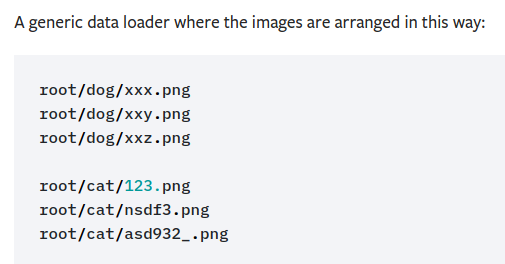

This is not very convenient for handling how data is provided in the Kaggle _Understanding the Amazon from Space_ challenge. This is easily fixable by implementing a custom sub-class of the torch Dataset class. Code below is based on https://www.kaggle.com/mratsim/starting-kit-for-pytorch-deep-learning#Loading-the-data---first-part---DataSet  

The implemented `KaggleAmazonDataset` makes use of [sklearn.preprocessing.MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html#sklearn-preprocessing-multilabelbinarizer) to encode the categorical labels in a convenient numerical format for the training.

In [7]:
class KaggleAmazonDataset(Dataset):
    """Dataset wrapping images and target labels for Kaggle - Planet Amazon from Space competition.

    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
        Transform (optional) object containing transformations to apply on imagery.
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None, number_samples=None):
    
        tmp_df = pd.read_csv(csv_path)

        # remove image causing error PIL.UnidentifiedImageError: cannot identify image file 'train/train-jpg/train_19242.jpg'
        # PIL.UnidentifiedImageError: cannot identify image file 'train/train-jpg/train_26184.jpg'
        # TODO: check if this file got corrupted when uploaded to Drive
        # idx = tmp_df.index[tmp_df['image_name'] == 'train_19242']
        # tmp_df = tmp_df.drop(idx)
        # idx = tmp_df.index[tmp_df['image_name'] == 'train_26184']
        # tmp_df = tmp_df.drop(idx)
        # idx = tmp_df.index[tmp_df['image_name'] == 'train_25428']
        # tmp_df = tmp_df.drop(idx)
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        # check that all images listed in the train.csv are available on the training folder
        assert tmp_df['image_name'].apply(lambda x: os.path.isfile(os.path.join(
                self.img_path, x + self.img_ext))).all(), \
"Some images referenced in the CSV file were not found"

        for image_name in tmp_df['image_name']:
          file_size = os.stat(os.path.join(
              self.img_path, image_name + self.img_ext)).st_size
          if file_size == 0:
            print(image_name)

        image_names = tmp_df['image_name']
        tags = tmp_df['tags']
        if number_samples:
          image_names = image_names[:number_samples]
          tags = tags[:number_samples]
          self.dataset_size = number_samples
        else:
          self.dataset_size = len(image_names)



        self.X_train = image_names
        # self.y_train is a sparse-matrix of size num_samples x num_classes where an element [i,j] equals 1 
        # iff the sample with index 'i' correspond to class 'j'
        self.y_train = self.mlb.fit_transform(tags.str.split()).astype(np.float32)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.X_train[index] + 
                                      self.img_ext))
        img = img.convert('RGB')
        if self.transform is not None:
          img = self.transform(img)

        label = torch.from_numpy(self.y_train[index])
        return img, label
    
    def decode_binary_label(self, array):
      return self.mlb.inverse_transform(array)

    def __len__(self):
        return len(self.X_train.index)

## Load training data

In [8]:
# the parameters used here are based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


data_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      # Normalization mean and std. dev. 
                                      # factors are taken from ImageNet
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])])

train_dataset = KaggleAmazonDataset('train_v2.csv', TRAIN_DIR, '.jpg', 
                                    data_transforms)

train_loader = DataLoader(train_dataset,
                          batch_size=125,
                          shuffle=True,
                          num_workers=1, # 1 for CUDA
                          pin_memory=True # CUDA only
                         )

dataset_sizes = {'train': train_dataset.dataset_size}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

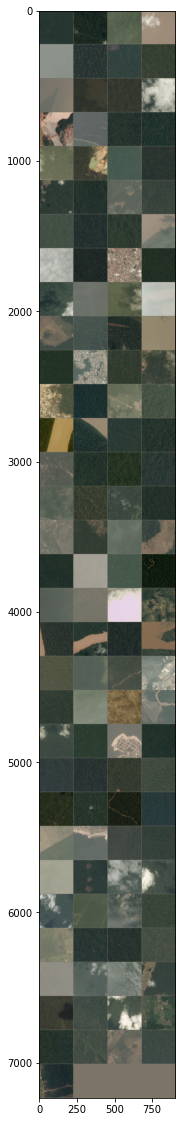

In [9]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

imshow(out, fig_size=20)

In [10]:
train_dataset.decode_binary_label(classes)
# classes[0]

[('clear', 'primary'),
 ('partly_cloudy', 'primary'),
 ('haze', 'primary'),
 ('cloudy',),
 ('cloudy',),
 ('clear', 'primary'),
 ('clear', 'cultivation', 'primary'),
 ('clear', 'primary'),
 ('clear', 'primary', 'water'),
 ('clear', 'primary'),
 ('clear', 'primary'),
 ('partly_cloudy', 'primary', 'water'),
 ('clear', 'conventional_mine', 'primary', 'road', 'water'),
 ('clear', 'primary', 'water'),
 ('clear', 'primary'),
 ('clear', 'primary'),
 ('partly_cloudy', 'primary'),
 ('artisinal_mine', 'clear', 'primary'),
 ('clear', 'primary', 'water'),
 ('clear', 'primary'),
 ('cultivation', 'habitation', 'partly_cloudy', 'primary', 'road'),
 ('clear', 'primary'),
 ('agriculture', 'clear', 'cultivation', 'primary'),
 ('clear', 'primary'),
 ('clear', 'primary'),
 ('clear', 'primary'),
 ('clear', 'primary'),
 ('agriculture', 'partly_cloudy', 'primary', 'water'),
 ('cloudy',),
 ('clear', 'primary'),
 ('clear', 'habitation', 'road'),
 ('clear', 'primary'),
 ('partly_cloudy', 'primary'),
 ('haze', 'p

## Train model

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, save_model=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = outputs > 0 
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_model:
                  torch.save({
                      'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss': epoch_loss,
                      'accuracy': epoch_acc
                      }, MODEL_PATH)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Finetunning the convnet

In [12]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
num_classes = len(train_dataset.mlb.classes_)
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()
# Loss selected for multi-label classification problem based on https://discuss.pytorch.org/t/multi-label-classification-in-pytorch/905/45
criterion = nn.BCEWithLogitsLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_ft.parameters(), lr=2e-1, weight_decay=5e-7)
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
load_model = False
if load_model:
  checkpoint = torch.load(MODEL_PATH)
  model_ft.load_state_dict(checkpoint['model_state_dict'])
  optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=30, save_model=True)

Epoch 0/29
----------
